In [1]:
print('Hello world!')

Hello world!


### Experimental Setting

In [2]:
REVERSE_INPUT = True
REVERSE_OUTPUT = True
OPERATOR = '+'
NUM1_RANGE = (0,999)
NUM2_RANGE = (0,999)
TRAINING_SAMPLE_SIZE =10000
TEST_SAMPLE_SIZE = 100
TRAINING_EPOCH = 50

### Transformer for Calculation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        return num1+operator+num2+'='+result

In [7]:
# Hyperparameter
MAX_LEN = 16
EMBED_SIZE = 384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 3 #6 #3
DROPOUT = 0 #0.1
LEARNING_RATE = 1e-6 #1e-3
EPOCHS = TRAINING_EPOCH

In [8]:
# TODO: delete
n_embd = EMBED_SIZE
block_size = MAX_LEN
n_layer = NUM_LAYERS
dropout = DROPOUT

In [9]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11}
TOKENS = ''.join(ONEHOT_IDX.keys())
VOCAB_SIZE = len(TOKENS)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return TOKENS[idx]

In [10]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [11]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [14]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(max_len, embed_size)
        self.blocks = nn.Sequential(*[Block(embed_size, n_head=num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_size) # final layer norm
        self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        return logits


In [15]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=8)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 14))

    pc_axes = [[0,1],[2,3],[4,5],[6,7]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(2, 2, plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png', bbox_inches='tight')
        plt.close()

# vis_pca(model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device)), TOKENS, title='Test', show=True)

In [16]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

e:\arithmeticGPT-simple\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [18]:
model = model.to(device)

In [19]:
PCA_TITLE_PREFIX = "TOP-8 Embedding PCA"

In [20]:
emb_func = model.token_embedding_table

In [21]:
data = emb_func(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:0, Loss:N/A)')

In [22]:
# Train
model.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            output_onehot = np.argmax(output.cpu().detach(), axis=2)  # (batch=1, seq_len)
            
            pred = output.view(-1, VOCAB_SIZE)  # (seq_len, VOCAB_SIZE)
            true = target_tensor.view(-1)  # (seq_len)
            # loss = F.cross_entropy(pred, true)  # Compare all (inefficient)
            
            eqi = data[:-1].index('=')
            lhs = torch.zeros_like(pred[:eqi])
            for i in range(eqi):
                lhs[i][true[i]] = 1
            rhs_pred = torch.cat((lhs, pred[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
            loss = F.cross_entropy(rhs_pred, true)  # Compare RHS
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/len(batch)
    losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    data = emb_func(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
    vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:{epoch+1}, Loss:{losses[-1]:.2f})')

plt.title('Loss'); plt.plot(losses)

100%|██████████| 10000/10000 [03:05<00:00, 53.86it/s]


Epoch 1, Loss: 1.784134452879429


100%|██████████| 10000/10000 [03:31<00:00, 47.19it/s]


Epoch 2, Loss: 1.7507156111359596


100%|██████████| 10000/10000 [03:35<00:00, 46.35it/s]


Epoch 3, Loss: 1.748005974817276


100%|██████████| 10000/10000 [03:39<00:00, 45.49it/s]


Epoch 4, Loss: 1.7469298564314841


100%|██████████| 10000/10000 [03:40<00:00, 45.30it/s]


Epoch 5, Loss: 1.7462207366347313


100%|██████████| 10000/10000 [03:41<00:00, 45.06it/s]


Epoch 6, Loss: 1.7456130874752998


100%|██████████| 10000/10000 [03:41<00:00, 45.12it/s]


Epoch 7, Loss: 1.7450065529108048


100%|██████████| 10000/10000 [03:41<00:00, 45.19it/s]


Epoch 8, Loss: 1.7443235303878784


100%|██████████| 10000/10000 [03:40<00:00, 45.35it/s]


Epoch 9, Loss: 1.7434484099268914


100%|██████████| 10000/10000 [03:33<00:00, 46.78it/s]


Epoch 10, Loss: 1.742143963265419


100%|██████████| 10000/10000 [03:33<00:00, 46.91it/s]


Epoch 11, Loss: 1.7399068315386772


100%|██████████| 10000/10000 [03:35<00:00, 46.51it/s]


Epoch 12, Loss: 1.735873226606846


100%|██████████| 10000/10000 [03:30<00:00, 47.52it/s]


Epoch 13, Loss: 1.7286134745955468


100%|██████████| 10000/10000 [03:33<00:00, 46.87it/s]


Epoch 14, Loss: 1.7135644323468209


 22%|██▏       | 2190/10000 [00:41<02:29, 52.14it/s]


KeyboardInterrupt: 

In [ ]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)
    
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)
                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  885+685=4711
target_char:  ['4', '7', '1', '1']
output_char:  ['0', '6', '1', '1']
sentence:  265+055=2111
target_char:  ['2', '1', '1', '1']
output_char:  ['3', '3', '8', '1']
sentence:  308+855=1631
target_char:  ['1', '6', '3', '1']
output_char:  ['8', '8', '9', '1']
sentence:  931+83=771
target_char:  ['7', '7', '1']
output_char:  ['9', '9', '7']
sentence:  457+475=8231
target_char:  ['8', '2', '3', '1']
output_char:  ['1', '8', '8', '1']
sentence:  497+488=8761
target_char:  ['8', '7', '6', '1']
output_char:  ['8', '8', '4', '1']
sentence:  153+02=173
target_char:  ['1', '7', '3']
output_char:  ['9', '7', '2']
sentence:  477+462=8301
target_char:  ['8', '3', '0', '1']
output_char:  ['1', '8', '8', '1']
sentence:  195+035=1211
target_char:  ['1', '2', '1', '1']
output_char:  ['3', '4', '8', '1']
sentence:  609+604=2131
target_char:  ['2', '1', '3', '1']
output_char:  ['9', '9', '1', '1']
sentence:  548+007=5451
target_char:  ['5', '4', '5', '1']
output_char:  ['3', '8', 

In [ ]:
print("Accuracy: ", accuracy)

Accuracy:  0.27624309392265195


In [ ]:
# Write experimental results
if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
filename=f'exp_res/{accuracy*100:.0f}-InRev{REVERSE_INPUT}-OutRev{REVERSE_OUTPUT}-{NUM1_RANGE}-{NUM2_RANGE}-Train{TRAINING_SAMPLE_SIZE}-Test{TEST_SAMPLE_SIZE}-Epoch{TRAINING_EPOCH}-{time.strftime("%Y%m%d-%H%M%S")}.txt'
with open(filename, 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Loss: {losses}\n')

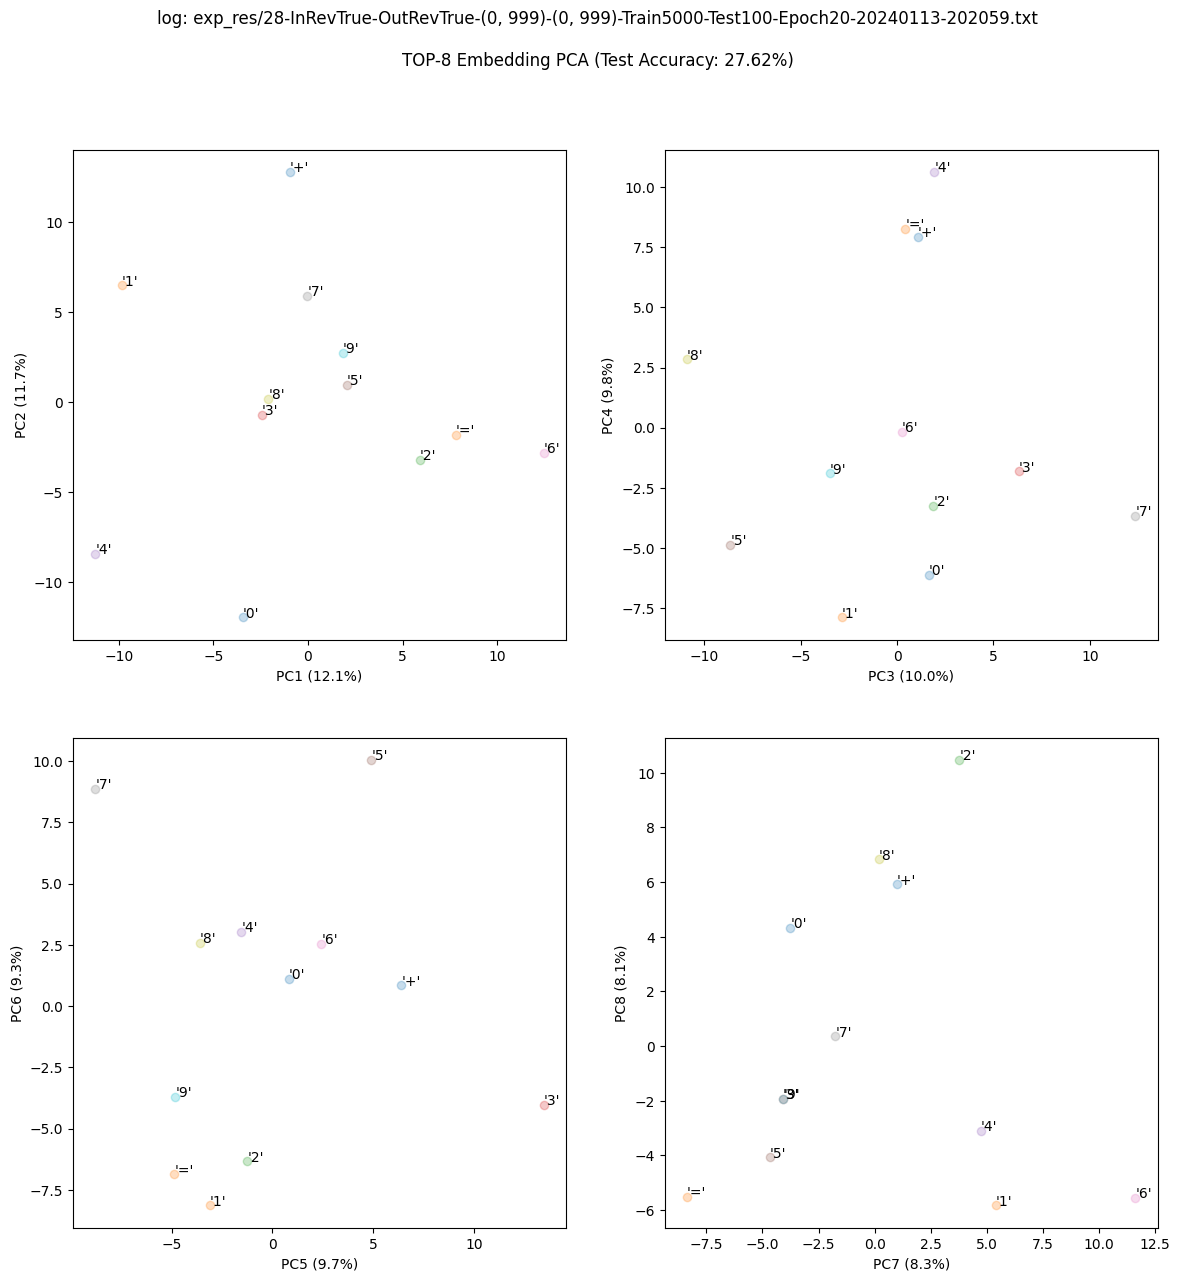

In [ ]:
vis_pca(data, TOKENS, title=f'log: {filename}\n\n{PCA_TITLE_PREFIX} (Test Accuracy: {accuracy*100:.2f}%)', show=True)